# The transient universe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import emcee
import pandas as pd

1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [2]:
f = np.load('../astroML_data/transient.npy')
pd.DataFrame(f, columns = ['time', 'flux', 'error'])

,time,flux,error
0,0.469548,8.834850,1.0
1,1.878980,10.900826,1.0
2,2.010755,10.465662,1.0
3,2.021840,8.463756,1.0
4,3.918779,11.488252,1.0
...,...,...,...
95,96.366276,10.730046,1.0
96,97.645947,9.239222,1.0
97,97.676109,9.352954,1.0
98,97.861834,9.586189,1.0


In [3]:
data = f.transpose()
t, fl, err_fl = data

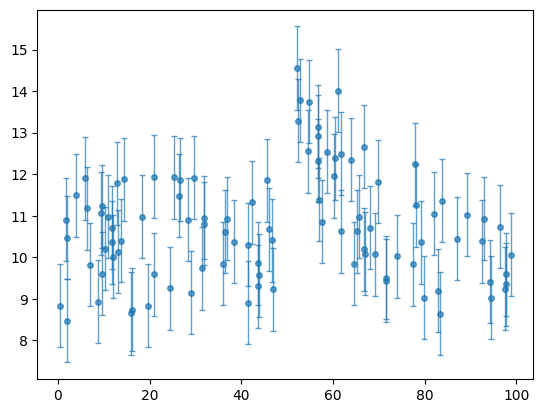

In [4]:
plt.errorbar(t,fl, yerr=err_fl, fmt='o', capsize=2, capthick=1, lw = 1, markersize = 4, alpha = .7);

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:
    $y = b$, for $t<t_0$

    $y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

    where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.
    Code this burst model, and code a likelihood function for this data with the burst model. <br>
    *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.*

In [5]:
def burst(t, b, A, t0, alpha):
    y = np.zeros(len(t))
    #t is an array
    for i,t_i in enumerate(t):
        if t_i < t0:
            y[i] = b
        else:
            y[i] = b + A*np.exp(-alpha*(t_i-t0))
    return y

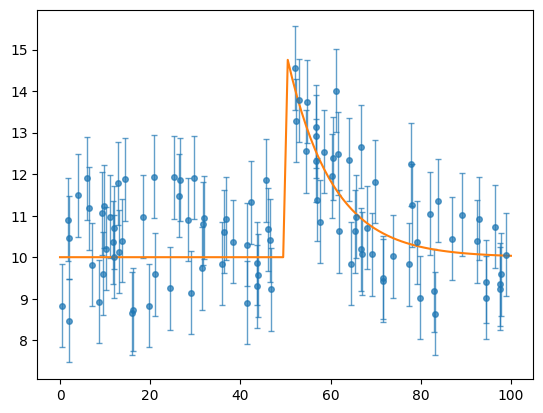

In [6]:
plt.errorbar(t, fl, yerr=err_fl, fmt='o', capsize=2, capthick=1, lw = 1, markersize = 4, alpha = .7)

#fitting data by eye
tt = np.linspace(0,100,100)
plt.plot(tt, burst(tt, b=10, A=5, t0=50, alpha=0.1));

In [7]:
from scipy import stats

#p is my parameter array
def loglikelihood(p, data, model=burst):
    #defining my parameters theta = p
    b, A, t0, alpha = p
    x, y, sigma_y = data
    
    y_fit = model(x, b, A, t0, alpha)
    
    # the definition of likelihood is the product of the probabilities,
    # my data is distributed like my model, here i'm computing the likelihood
    # assuming gaussian singular likelihoods of my data, which is always a reasonable
    # assumption since it doesn't assume anything about how you generate the data
    
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y)) #y_fit is the center

In [8]:
#y_fit = burst(data[0], 30, 10, 80, -.2)

#for args in zip(data[1], y_fit, data[2]):
#    print(*args)

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

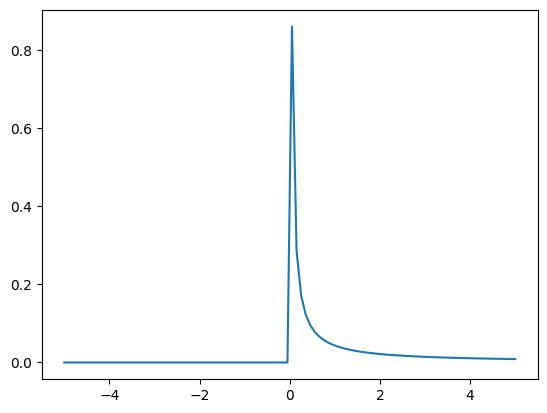

In [9]:
#alpha prior distribution
x = np.linspace(-5,5,100)
y = stats.loguniform.pdf(x, a=1e-5, b=1e5, loc=1e-5)
plt.plot(x,y);

In [10]:
def prior(p): #function of the parameters i will give to emcee
    priors = np.zeros(4)
    #in this case all parameters are independent so the prior is the product of all priors
    #the p(loga) = uniform means p(a) = 1/uniform
    priors[0] = stats.uniform.pdf(p[0], loc=0, scale=50) #this will generate the pdf in the domain [0,50]
    priors[1] = stats.uniform.pdf(p[1], loc=0, scale=50)
    priors[2] = stats.uniform.pdf(p[2], loc=0, scale=100)
    priors[3] = stats.loguniform.pdf(p[3], a=1e-5, b=1e5)
    return np.prod(priors)


# emcee wants ln of posterior pdf
def logpost(p, data):
    lp = np.log(prior(p))
    if not np.isfinite(lp):
        return -np.inf
    else:
        return loglikelihood(p, data) + lp #log of the product

In [14]:
import emcee

ndim = 4       # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 10000  # number of MCMC steps to take **for each walker**

In [15]:
# initialize parameters
np.random.seed(1)
starting_guesses = np.zeros([nwalkers, ndim])

for i in range(nwalkers):
    # you want to initialize the guesses at a reasonable value, recall the fit by hand
    starting_guesses[i,0] = 10 + 1e-2*np.random.uniform(0,50)
    starting_guesses[i,1] = 5 + 1e-2*np.random.uniform(0,50)
    starting_guesses[i,2] = 50 + 1e-2*np.random.uniform(0,100)
    starting_guesses[i,3] = 0.1 + 1e-2*np.exp(np.random.uniform(-5,5))

print(starting_guesses)

[[10.208511    5.36016225 50.00011437  0.10138529]
 [10.07337795  5.0461693  50.18626021  0.10213441]
 [10.19838374  5.26940837 50.41919451  0.16373795]
 [10.10222612  5.43905872 50.02738759  0.15499599]
 [10.2086524   5.27934491 50.14038694  0.10048851]
 [10.40037228  5.48413079 50.31342418  0.16842999]
 [10.43819458  5.44730333 50.08504421  0.10009957]
 [10.08491521  5.43907125 50.09834683  0.10454334]
 [10.47894477  5.26658264 50.69187711  0.1015805 ]
 [10.34325046  5.41731284 50.01828828  0.22200088]]


In [16]:
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=[data])
sampler.run_mcmc(starting_guesses, nsteps)
print('done')

/tmp/ipykernel_15936/694735065.py:14: RuntimeWarning: divide by zero encountered in log
  lp = np.log(prior(p))


done


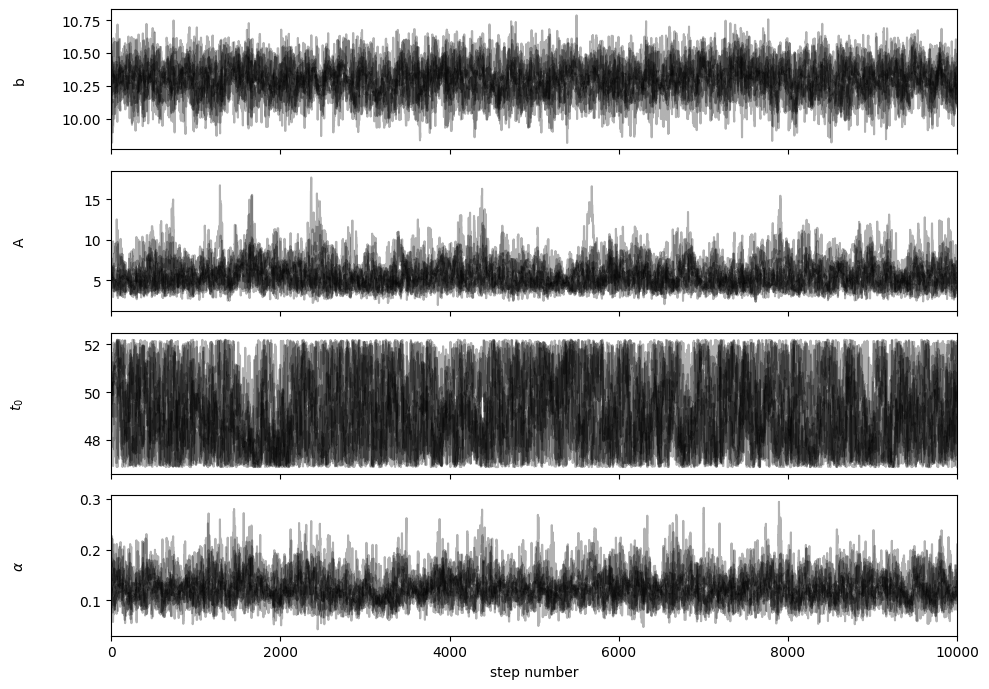

In [18]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True, tight_layout = True)
samples = sampler.get_chain()
labels = [r'b', r'A', r'$t_0$', r'$\alpha$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [19]:
#save to file without having to run again
with open('E11_chain.npy', 'wb') as f:
    np.save(f, samples)

In [20]:
#with open('E11_chain.npy', 'rb') as f:
#    samples = np.load(f)

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [21]:
samples.shape

(10000, 10, 4)

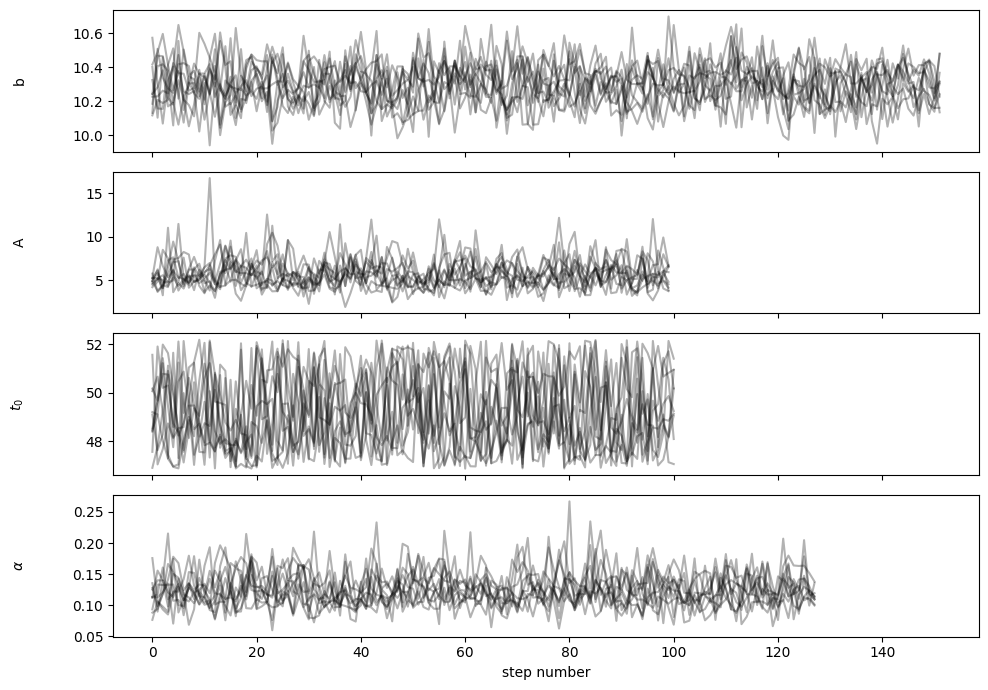

In [24]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True, tight_layout = True)
labels = [r'b', r'A', r'$t_0$', r'$\alpha$']
burn = 100
time = sampler.get_autocorr_time()

for i in range(ndim):
    ax = axes[i]
    samples = sampler.get_chain(discard=burn, thin=round(time[i]))
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### back to the analysis

In [25]:
print(time)

[65.07542362 98.74543532 97.69647692 76.94515577]


In [32]:
flat_samples = sampler.get_chain(discard=burn, thin=65, flat=True)
print(flat_samples.shape)

(1520, 4)


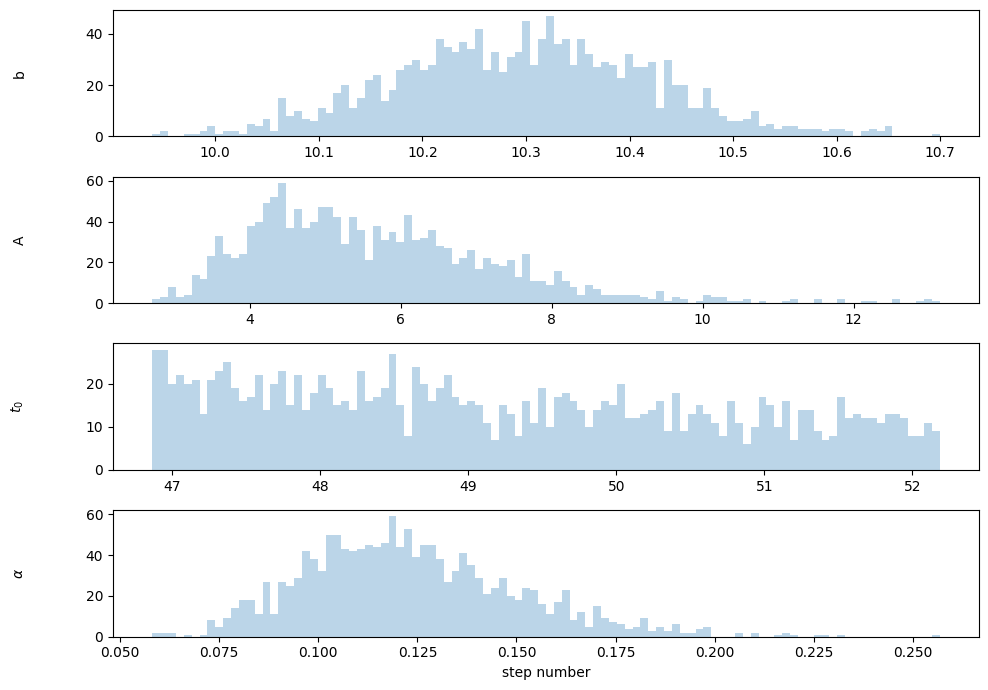

In [33]:
fig, axes = plt.subplots(4, figsize=(10, 7), tight_layout = True)
labels = [r'b', r'A', r'$t_0$', r'$\alpha$']
burn = 100
w = 0 #walker

for i in range(ndim):
    ax = axes[i]
    ax.hist(flat_samples[:, i], bins = 100, alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

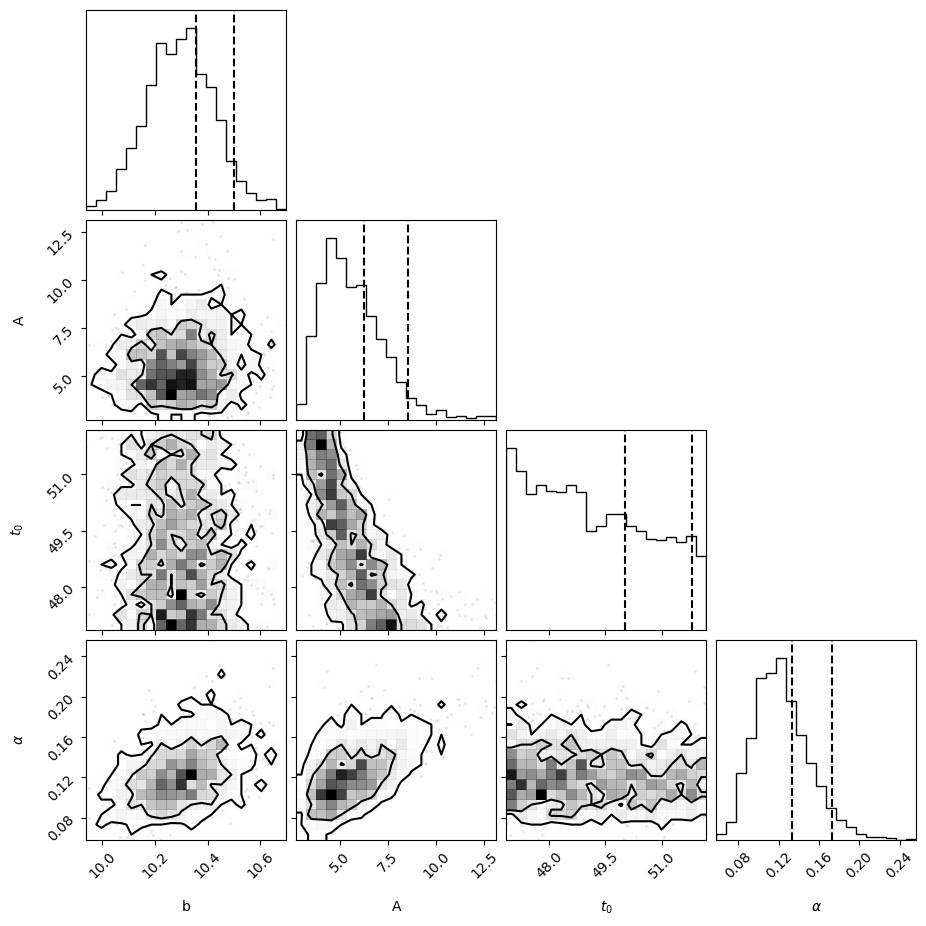

In [34]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, levels=[0.68, 0.95], truths=[1,1,1,1], quantiles=[.68,.95]
);

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

(102, 4)


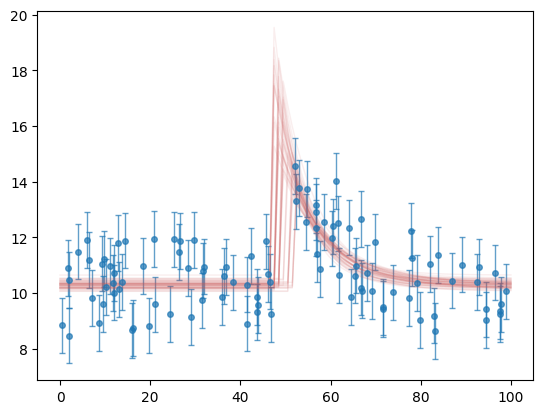

In [37]:
plt.errorbar(t, fl, yerr=err_fl, fmt='o', capsize=2, capthick=1, lw = 1, markersize = 4, alpha = .7)
tt = np.linspace(0,100,100)

p = flat_samples[::round(len(flat_samples)/100), :] #taking one parameter per 100 for each parameter chain
print(p.shape)

for i in range(50):
    plt.plot(tt, burst(tt, b=p[i,0], A=p[i,1], t0=p[i,2], alpha=p[i,3]), 'indianred', alpha = .1, lw = 1);

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

In [38]:
#the 90% credible region is the interval bw the 5th and 95th percentile, so my error will be 95-5
labels = ['b', 'A', 't0', 'alpha']
header = ['med', r'$\sigma_-$', r'$\sigma_+$', r'$\sigma_{90}$']
stats = [] 

for i,l in enumerate(labels):
    low,med,up = np.percentile(flat_samples[:,i],[5,50,95])
    stats.append([round(med,3), round(up-med,3), round((low-med)/2,3), round((up-med)/2,3)])

df = pd.DataFrame(stats, columns=header, index=labels)
df.style.set_table_attributes('style="font-size: 17px"')

display(df)

,med,$\sigma_-$,$\sigma_+$,$\sigma_{90}$
b,10.300,0.201,-0.104,0.101
A,5.380,3.147,-0.906,1.574
t0,48.964,2.838,-0.969,1.419
alpha,0.120,0.052,-0.018,0.026
